# CompanyName Data Science Challenge

An important application of data science at CompanyName is to protect our merchants from fraudulent transactions. Fraudulent transactions happen when a fraudster steals a legit customer's credit card, and uses it to unlawfully buy goods online. For this reason, CompanyName has a risk system in place that can refuse a transaction if it is suspected to be fraudulent. The overall goal is to reject as much fraud as possible, without compromising legit customers.

CompanyName knows that a transaction was fraudulent when it receives a chargeback. A chargeback is a notification from the card network that the amount of the transaction must be refunded to the legit customer. A chargeback can only happen on approved payments (i.e. if it was refused by our risk system or by the bank, money doesn't get deducted from the legit customer's account, thus no chargebacks can happen).


In this challenge, your goal is to train a model to predict which transaction might be fraudulent and improve CompanyName's risk system. What is important for our merchants is that the chargeback rate should at all time stay below 1%, while keeping revenue as high as possible. A chargeback costs them 15 EUR, +50% of the price of the goods (in the form of lost goods that they sent to the fraudster). While declining a transaction that turned out to be non-fraudulent (false positive) also costs them 50% of the price of the goods (in the form of missed revenue).

## The dataset

In the dataset provided you'll find 30 days of payment data for a few merchants, a merchant is a client for which we process payments, e.g. an e-commerce website, different merchants are not necessarly different companies.

The dataset contains the following columns:

| Field | Explanation|
|:-----:| :------------------ |
| merchant | The id of our client |
| first_6_digit | The first 6 digit of the credit card used in the transaction which was recieved by our client |
| payment_ref | The unique reference for this payment |
| amount_eur | The amount in euros |
| card_network | The network that emitted the card (shown as SchemeX, where X is variable)|
| card_type | The type of card (debit,credit...)|
| timestamp | The timestamp when this specific payment was received |
| device_info | Information about the device used to perform the payment |
| risk_checks | A list of lists, each sub-list contains a weight in first position and a rule (ID) in the second. The weight (which we call a risk score) which is assigned to each rule is directly proportional to the likelihood of the payment being fraudulent (negative: unlikely to be fraudulent, zero: check is performed but not seen as important, above zero: more likely to be fraudulent).  Merchants can create custom rules to flag some payments as fraudulent. The weight can also be assigned manually. Not all possible checks might be triggered by a payment (eg. a check might be relevant only for one country) so not all the possible checks are always present in the list, in other words, not all checks are the same for each datarow.|
| refused_by_CompanyName_risk | Some of the risk-checks (rules) can force a payment to be refused; a refuse can also be caused by a predefined threshold on the risk-checks, such that if the score of the different rules exceed the threshold, the payment can be refused.|
| refused_by_bank | A payment can also be refused by the bank for various reasons (lack of funds, card lost etc..)|
| bank_country_id | The country ID of the bank |
| user_id | The id of the user that is performing the payment, this can be used to identify users performing multiple payments. Usually a fraudulent payment is enough to identify the user as fraudster, this means that all of their payments can be considered fraudulent.   |
| user_country_id | The country of the user that is performing the payment |
| autorised_times | An array that contains up to 50 timestamps of the most recent accepted payments of this user on our platform. If there are no previously known approved payments of this user on our platform the array is empty. |
| received_dates | An array that contains up to 50 timestamps of the most recent previously requested payments, populated only if the user has requested other payments on our platform before.|
| billing_address_dates | An array which contains the timestamps when a payment request with a different billing address was received, an empty list means we never receveived a request with a different address.
| delivery_address_dates | An array that will contain the timestamps when a payment request with a different delivery address was received, an empty list means we never receveived a request with a different delivery address.|
| ip_dates | An array that will contain the timestamps when a payment request with a different ip address, compared to the first payment, was received; an empty list means we never receveived a request with a different address. This list can be seen as a set.|
| is_fraud | Wether the payment was flagged as fraudulent. This happens when we receive a notification from the bank and can only happen for payments that were not already refused by CompanyName or by the bank.|


## Aim of the Challenge 

The aim of this challenge is to understand how you approach both a new problem as a new dataset. In order to understand this process please include markdown cells in which you discuss your choices with regards to the data preparation and model choices.


## Rules
You can start working right in this Jupyter Notebook, save the results and send to submit it. The data which you will need is provided in different formats (csv, json, parquet), feel free to choose the one that is most convienent for you.

(We will optionally accept submission in any other language/format as long as it comes with the full code and there is a clear explanation on how to execute it.)

Also there are bonus points if you can make your model into a REST API.

We kindly ask to submit your results within 48 hours since receiving this challenge.


### Read the dataset

In [1]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pylab as plt
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In the instructions it is mentioned that when CompanyName or the bank reject the transaction, we will never see a chargeback.
Since those transaction can thoritaclly be fraudlent it lead to a bias. Therefore, I have decided to remove all of those occurences.
I see this model as some kind of a decorator on top of all the other rejects/models, which mean that this model will kick in only after CompanyName and the bank gave their prediction. 

In [2]:
rawData_pd = pd.read_json('SupervisedChallenge.json',orient='records',lines=True)
cleanRawData_pd = rawData_pd[(rawData_pd['refused_by_bank']==0) & (rawData_pd['refused_by_CompanyName_risk']==0)]

# Exploratory Analysis

In [3]:
cleanRawData_pd.head()

,merchant,first_6_digits,payment_ref,amount_eur,card_network,card_type,timestamp,device,risk_checks,refused_by_CompanyName_risk,refused_by_bank,bank_country_id,user_id,user_country_id,authorised_times,received_dates,billing_address_dates,delivery_address_dates,ip_dates,is_fraud
0,Shop8,96543.0,78089c3946037ca9,0.00,SchemeF,DEBIT,2016-03-16 23:12:52,"[iPod, Mobile]","[[0, 82d8a3c9f6], [5, 6fe65e5dbc], [0, 5e9071e...",0,0,0.0,2.673933e+09,0.0,"[1458087107, 1458087043]","[1458169910, 1458169865, 1458169860, 145816981...",[],[],"[1458169910, 1458087107]",0
2,Shop2,535041.0,75517f4497a164e1,6.00,SchemeF,CREDIT,2016-03-20 21:24:54,None,"[[-50, 82d8a3c9f6], [-100, c802faf604], [0, 7d...",0,0,2.0,2.238808e+09,2.0,"[1450624829, 1450466297, 1450376979, 144585067...","[1458509094, 1450624829, 1450466297, 145037697...",[],[],"[1458509094, 1450624829, 1450466297, 145037697...",0
3,Shop2,314986.0,aeecc3a05e7f472c,23.38,SchemeB,DEBIT,2016-04-12 21:00:15,"[Windows, Desktop]","[[-80, 82d8a3c9f6], [30, 4c1c7b7377], [-100, c...",0,0,6.0,2.104261e+09,3.0,"[1460494740, 1460494644, 1460494583, 146049447...","[1460494815, 1460494740, 1460494644, 146049458...",[],[],"[1460494815, 1459523677, 1459293160, 145886088...",0
5,Shop2,893427.0,3de199afd69c4f31,64.00,SchemeI,CREDIT,2016-04-12 07:01:53,"[Windows Mobile, Mobile]","[[-50, 82d8a3c9f6], [25, a21c28cbc9], [-100, c...",0,0,6.0,1.188328e+09,3.0,"[1442253188, 1442253136, 1437764636, 143776114...","[1460444513, 1442253188, 1442253136, 143776463...",[],[],"[1460444513, 1404146199]",0
6,Shop3,597316.0,fa2a97d79246bcce,3.50,SchemeF,DEBIT,2016-04-27 22:33:36,None,"[[0, 82d8a3c9f6], [0, 7dc2bdd9d4], [70, cb61f1...",0,0,7.0,2.587504e+09,7.0,"[1461786218, 1461755673, 1461715418, 146171327...","[1461796416, 1461786218, 1461755673, 146171541...",[],[],"[1461796416, 1461786218, 1461755673, 1455451171]",0


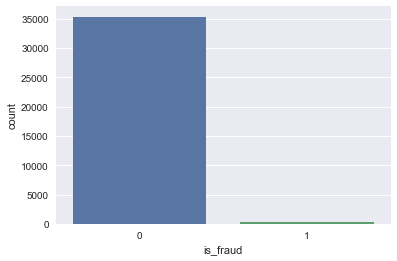

In [4]:
sns.countplot('is_fraud', data=cleanRawData_pd)

In the chart we see that the dataset is heaveily unbalanced (which is usually the case for fraud detection), that will influence lots of our calculation, metrics, etc.

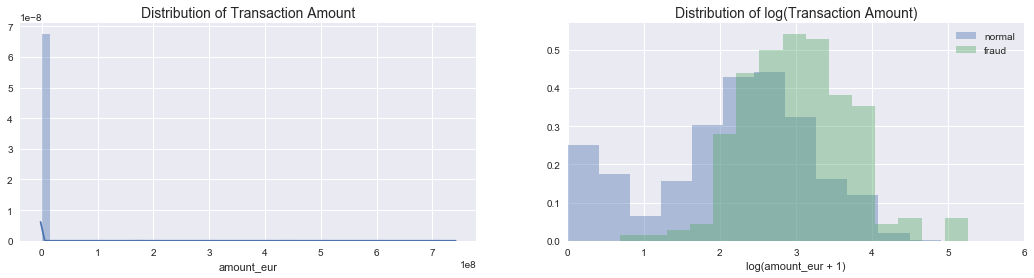

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

plotData_pd = cleanRawData_pd['amount_eur'][(cleanRawData_pd['is_fraud']==0)]
sns.distplot(plotData_pd, label='normal', ax=ax[0])
plotData_pd = cleanRawData_pd['amount_eur'][(cleanRawData_pd['is_fraud']==1)]
sns.distplot(plotData_pd, label='fraud', ax=ax[0])
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)

plotData_pd = np.log(cleanRawData_pd['amount_eur'][(cleanRawData_pd['is_fraud']==0)] + 1)
sns.distplot(plotData_pd, label='normal', ax=ax[1], kde=False, norm_hist=True)
plotData_pd = np.log(cleanRawData_pd['amount_eur'][(cleanRawData_pd['is_fraud']==1)] + 1)
sns.distplot(plotData_pd, label='fraud', ax=ax[1], kde=False, norm_hist=True)
ax[1].set_title('Distribution of log(Transaction Amount)', fontsize=14)
ax[1].set_xlim(0,6)
plt.xlabel('log(amount_eur + 1)')
plt.legend()

Fraud transactions tend to be with higher amount. In addition, we should use log(euro) instead of simple euro

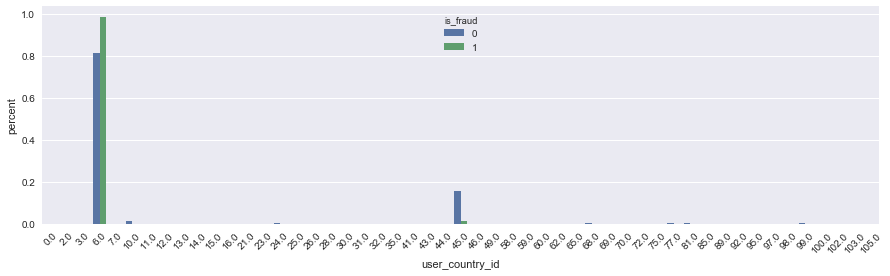

In [6]:
plt.figure(figsize=(15,4))

plotData_pd = cleanRawData_pd.groupby('is_fraud')['user_country_id'].value_counts(normalize=True).reset_index(name='percent')
chart = sns.barplot(data=plotData_pd, hue='is_fraud', x='user_country_id', y='percent')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

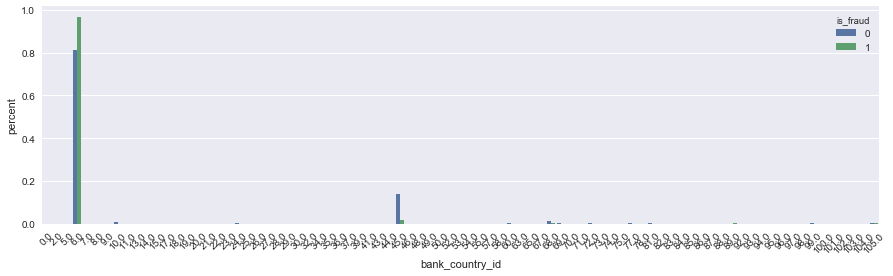

In [7]:
plt.figure(figsize=(15,4))

plotData_pd = cleanRawData_pd.groupby('is_fraud')['bank_country_id'].value_counts(normalize=True).reset_index(name='percent')
chart = sns.barplot(data=plotData_pd, hue='is_fraud', x='bank_country_id', y='percent')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

We see two dominant countries, we can later reduce dimensions (countries)

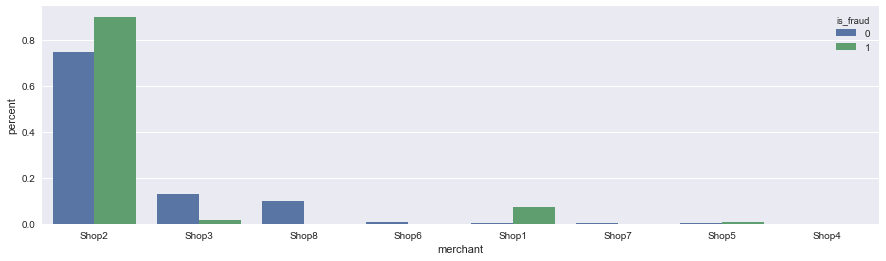

In [8]:
plt.figure(figsize=(15,4))

plotData_pd = cleanRawData_pd.groupby('is_fraud')['merchant'].value_counts(normalize=True).reset_index(name='percent')
sns.barplot(data=plotData_pd, hue='is_fraud', x='merchant', y='percent')

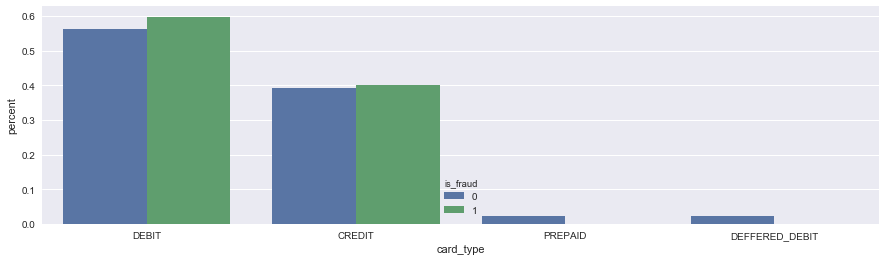

In [9]:
plt.figure(figsize=(15,4))

plotData_pd = cleanRawData_pd.groupby('is_fraud')['card_type'].value_counts(normalize=True).reset_index(name='percent')
sns.barplot(data=plotData_pd, hue='is_fraud', x='card_type', y='percent')

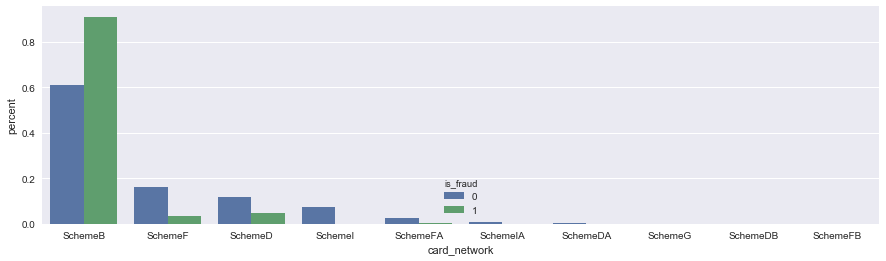

In [10]:
plt.figure(figsize=(15,4))

plotData_pd = cleanRawData_pd.groupby('is_fraud')['card_network'].value_counts(normalize=True).reset_index(name='percent')
sns.barplot(data=plotData_pd, hue='is_fraud', x='card_network', y='percent')

# Feature Engineering

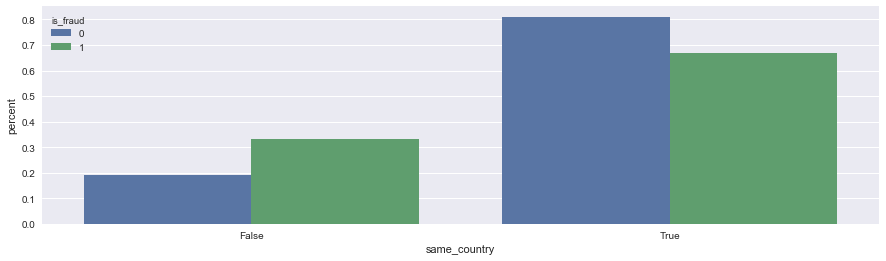

In [11]:
# Adding a feature of user country and bank country are the same

cleanRawData_pd['same_country'] = cleanRawData_pd['bank_country_id']==cleanRawData_pd['user_country_id']

# Visual of the new feature
plt.figure(figsize=(15,4))

plotData_pd = cleanRawData_pd.groupby('is_fraud')['same_country'].value_counts(normalize=True).reset_index(name='percent')
sns.barplot(data=plotData_pd, hue='is_fraud', x='same_country', y='percent')

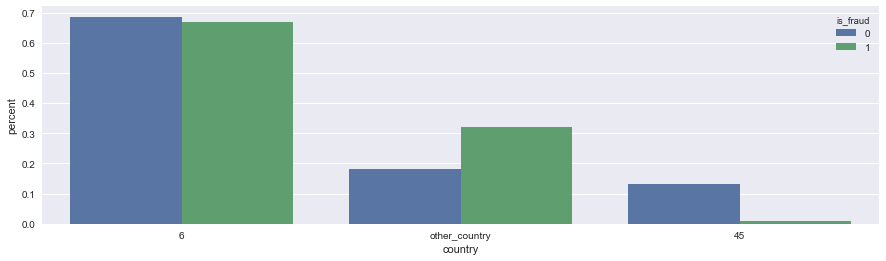

In [12]:
# Creating a compressed country column to reduce features

cleanRawData_pd['country'] = np.where(cleanRawData_pd['user_country_id'] == 6,'6',
                                      np.where(cleanRawData_pd['user_country_id'] == 45,'45','other_country'))

# Visual of the new feature
plt.figure(figsize=(15,4))

plotData_pd = cleanRawData_pd.groupby('is_fraud')['country'].value_counts(normalize=True).reset_index(name='percent')
sns.barplot(data=plotData_pd, hue='is_fraud', x='country', y='percent')

In [13]:
# Creating a log(Euro) feature as seen at the beginning of the notebook
cleanRawData_pd['log_euro'] = np.log(cleanRawData_pd['amount_eur'] + 1)

# Modelling and Validation


As we have seen in the start of the project the dataset is heavily unbalanced. There are 2 main ways to address this issue, under sample and over sample. <br>
In this phase of the project I will use both methodologies to check perfomance of the model.

### Random Under Sampling

Random Under Sampling is basically removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

In [14]:
features = ['merchant',
           'log_euro',
           'card_network',
           'card_type',
           'same_country',
           'country']

# one hot encoder for the categorical features
categoricalFeatures = ['merchant', 
                       'card_network',
                       'card_type',
                       'same_country',
                       'country']

encodedVariables = pd.get_dummies(cleanRawData_pd.loc[:, categoricalFeatures], prefix_sep='_', drop_first=True)
encodedCleanRawData_pd = pd.concat([cleanRawData_pd[list(features) + ['is_fraud']].drop(categoricalFeatures, 1), encodedVariables], axis=1)

encodedCleanRawData_pd.head()

,log_euro,is_fraud,same_country,merchant_Shop2,merchant_Shop3,merchant_Shop4,merchant_Shop5,merchant_Shop6,merchant_Shop7,merchant_Shop8,...,card_network_SchemeFA,card_network_SchemeFB,card_network_SchemeG,card_network_SchemeI,card_network_SchemeIA,card_type_DEBIT,card_type_DEFFERED_DEBIT,card_type_PREPAID,country_6,country_other_country
0,0.000000,0,True,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
2,1.945910,0,True,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3.193763,0,False,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
5,4.174387,0,False,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,1.504077,0,True,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


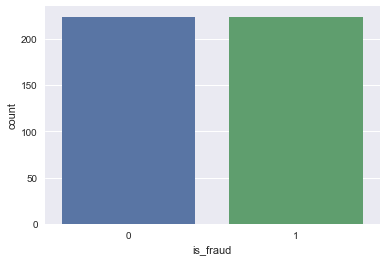

In [15]:
fraud_pd = encodedCleanRawData_pd[encodedCleanRawData_pd['is_fraud'] == 1]
nonFraud_pd = encodedCleanRawData_pd[encodedCleanRawData_pd['is_fraud'] == 0].sample(n=len(fraud_pd), random_state = 42)

encodedUnderSampleTransactions_pd = pd.concat([fraud_pd, nonFraud_pd]).sample(frac=1, random_state=42)
sns.countplot('is_fraud', data=encodedUnderSampleTransactions_pd)

In the next section we plot the learning curve of both logistic regression and decision tree models. <br>
We see that log reg get higer score. <br>

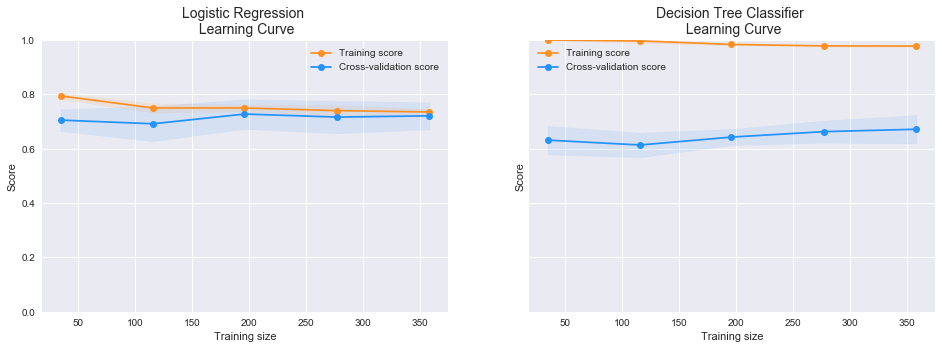

In [16]:
X_train = encodedUnderSampleTransactions_pd.drop('is_fraud', axis=1)                                                  
y_train = encodedUnderSampleTransactions_pd['is_fraud']

f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5), sharey=True)
plt.ylim(0,1)
# Logistic Regression
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(random_state=42), X_train, y_train)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="#ff9124")
ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
         label="Training score")
ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
         label="Cross-validation score")
ax1.set_title("Logistic Regression \n Learning Curve", fontsize=14)
ax1.set_xlabel('Training size')
ax1.set_ylabel('Score')
ax1.grid(True)
ax1.legend(loc="best")

# Decision Tree
train_sizes, train_scores, test_scores = learning_curve(DecisionTreeClassifier(random_state=42), X_train, y_train)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="#ff9124")
ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
         label="Training score")
ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
         label="Cross-validation score")
ax2.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
ax2.set_xlabel('Training size')
ax2.set_ylabel('Score')
ax2.grid(True)
ax2.legend(loc="best")

In the above charts we see that the decision tree is clearly overfitting, while log reg produce passable results. 

### Over sample using SMOTE

In this section we will try over sample instead of under sample. The main benfit of this method is that there is no information loss. However, we should be very careful not to "bleed" information from train to validation and test.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(encodedCleanRawData_pd.drop('is_fraud', axis=1), 
                                                  encodedCleanRawData_pd['is_fraud'], 
                                                  test_size = .1, 
                                                  random_state=42)

In [18]:
x_train, x_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size = .1, 
                                                  random_state=42)

In [19]:
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

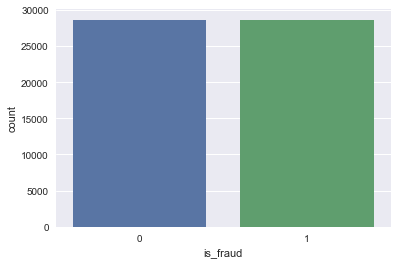

In [20]:
sns.countplot('is_fraud', data=pd.DataFrame(y_train_res))

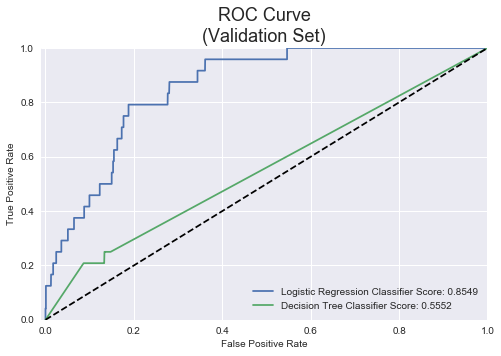

In [21]:
logReg_clf = LogisticRegression(random_state=42).fit(x_train_res, y_train_res)
tree_clf = DecisionTreeClassifier(random_state=42).fit(x_train_res, y_train_res)

logReg_pred = logReg_clf.predict_proba(x_val)[:,1]
tree_pred = tree_clf.predict_proba(x_val)[:,1]

log_fpr, log_tpr, log_thresold = roc_curve(y_val, logReg_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_val, tree_pred)

plt.figure(figsize=(8,5))
plt.title('ROC Curve\n(Validation Set)', fontsize=18)
plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_val, logReg_pred)))
plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_val, tree_pred)))
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.legend()

# Threshold

True Positive income - goods price <br>
True Negative costs - costs of blocking a fraud user (0 Euro) <br>
False Positive costs - cost of blocking a legitimate transaction (50% * goods price) <br>
False Negative costs - cost of, unblocking a fraduelent transaction, chargeback  (50% * goods price + 15 Euro) <br>

Net Revenue = <br>
(# of TP True Positive income) + <br>
(# of FP False Positive costs) + <br>
(# of FN False Negative costs) +

In [22]:
logRegTest_pred = logReg_clf.predict_proba(x_val)[:,1]

fpr, tpr, thresholds = roc_curve(y_val, logRegTest_pred)
result = np.where(tpr >= 0.99)[0][0]
print("Since we want to keep TPR at least 99%, our threshold should be: ", round((thresholds[result]), 4) * 100, "%")
print("(Based on validation dataset)")

Since we want to keep TPR at least 99%, our threshold should be:  30.14 %
(Based on validation dataset)


# Predict Class
Here I will start with pickle all the relevant objects, and build a fraud class that will later will be translated to an API

In [23]:
pickle.dump(logReg_clf, open('log_reg_model_v1.pickle', 'wb'))
pickle.dump(features, open('features.pickle', 'wb'))
pickle.dump(encodedVariables.columns, open('encodedVariables.pickle', 'wb'))
pickle.dump(thresholds[result], open('thresholds.pickle', 'wb'))

In [24]:
class fraudModel:
    def __init__(self):
        self.model = pickle.load(open('./log_reg_model_v1.pickle', 'rb'))
        self.features = pickle.load(open('./features.pickle', 'rb'))
        self.categoricalFeatures = ['merchant', 
                       'card_network',
                       'card_type',
                       'same_country',
                       'country']
        self.encodedCategoricalFeatures = pickle.load(open('./encodedVariables.pickle', 'rb'))
        self.threshold = pickle.load(open('./thresholds.pickle', 'rb'))

    def featureEncode(self):
        self.log_euro = np.log(1+self.euro)
        self.same_country = self.bank_country_id==self.user_country_id
        if self.user_country_id in [6, 45]:
            self.country = str(self.user_country_id)
        else:
            self.country = 'other_country'
        row_pd = pd.DataFrame([{'log_euro':self.log_euro,
              'merchant':self.merchant,
              'card_network':self.card_network,
              'card_type':self.card_type,
              'same_country':self.same_country,
              'country':self.country
             }])
        encodedrow_pd = pd.get_dummies(row_pd.loc[:, self.categoricalFeatures], prefix_sep='_')
        encoded_features = encodedrow_pd.reindex(columns = self.encodedCategoricalFeatures, fill_value=0)
        encodedrow_pd = pd.concat([row_pd[list(self.features)].drop(self.categoricalFeatures, 1), encoded_features], axis=1)
        return encodedrow_pd

    def predict(self, euro, card_network, card_type, bank_country_id, user_country_id, merchant):
        self.euro = euro
        self.merchant = merchant
        self.card_network = card_network
        self.card_type = card_type
        self.bank_country_id = card_network
        self.user_country_id = user_country_id
        row_pd = self.featureEncode()
        if self.model.predict_proba(row_pd)[:,1] >= self.threshold:
            return 1
        else:
            return 0

Exmple of using the class with random row from the original dataset


In [25]:
rawDataForTest_pd = pd.read_json('SupervisedChallenge.json',orient='records',lines=True)

In [26]:
# Exmple of using the class with random row from the original dataset
randRow_pd = rawDataForTest_pd.sample(1)

fraudModel().predict(euro = randRow_pd.amount_eur.values[0], 
                     card_network = randRow_pd.card_network.values[0], 
                     card_type = randRow_pd.card_type.values[0], 
                     bank_country_id = randRow_pd.bank_country_id.values[0], 
                     user_country_id = randRow_pd.user_country_id.values[0], 
                     merchant = randRow_pd['merchant'].values[0])

0

# Follow ups

That was a nice exercise, thanks.<br>
Due to lack of time I was reluctant to finish my plans. However, I hope this demonstrate well enough my skills :-)<br>
Anyway here is an outline of things I had in mind to add:
* check more models (random forest, xgboost, etc.)
* hyperparameter tuning with grid search
* add more features 
    * I've ignored completely the risk tests, which I guess can add lots of information
    * interaction between features (e.g card type and card network)
* Threshold - I've used (transaction) count, I would investigate (transaction) value threshold  
* Making the REST API more "production ready"